<a href="https://colab.research.google.com/github/NeeteshDadwariya/tweets-clustering-using-k-means/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Clustering Using K-Means

### Importing Libraries

In [ ]:
import string
import re
import os
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Downloading Dataset

In [ ]:
!gdown "1-4tJknU_0fzyyhb-v5A_qs8FlH1CIaCA"
!unzip -o Health-News-Tweets.zip &> /dev/null

In [ ]:
tweet_folder = './Health-Tweets'
tweet_file = 'nytimeshealth.txt'

#Reading the tweets file
with open(os.path.join(tweet_folder, tweet_file)) as f:
    tweets = f.readlines()

In [ ]:
print("Total tweets found:{}", len(tweets))

In [ ]:
def print_tweets(tweets):
    for tweet in tweets[:5]:
        print(tweet)

print_tweets(tweets)

### Data Preprocessing

In [ ]:
def pre_process_tweet(tweet):
    #Remove new lines
    tweet = tweet.lower().strip('\n')[50:]
    
    #Remove '@' symbol
    tweet = " ".join(filter(lambda x: x[0] != '@', tweet.split()))
    
    #Removel URL's
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"www\S+", "", tweet)
    tweet = tweet.strip()
    
    #Remove special characters
    tweet = re.sub(":", "", tweet)
    tweet = re.sub("#", "", tweet)

    #Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = re.sub("—", "", tweet)
    tweet = re.sub("‘","", tweet)
    tweet = re.sub("’","", tweet)
    return tweet

In [ ]:
def print_tweets(tweets):
    for tweet in tweets[:5]:
        print(tweet)

pre_process_tweets = [pre_process_tweet(tweet) for tweet in tweets]
print_tweets(pre_process_tweets)

### K-Means Alogirithm using Jacard Distance

In [ ]:
def compare_centroids(old_centroids, new_centroids):
  return old_centroids == new_centroids

def jaccard_dist(t1, t2):
    t1 = set(t1)
    t2 = set(t2)
    j = float(len(t1.intersection(t2))) / len(t1.union(t2))
    return 1-j

In [ ]:
def assign_cluster(tweets, centroids):

    clusters = dict()

    # Lop through each centroid and assign closest centroid to a it
    for t in range(len(tweets)):
        min_dist = math.inf
        cluster_idx = -1;
        for c in range(len(centroids)):
            dist = jaccard_dist(centroids[c], tweets[t])
            # Find the closest center of the tweet
            if centroids[c] == tweets[t]:
                cluster_idx = c
                min_dist = 0
                break

            if dist < min_dist:
                cluster_idx = c
                min_dist = dist

        # randomise the centroid assignment to a tweet if nothing is common
        if min_dist == 1:
            cluster_idx = random.randint(0, len(centroids) - 1)

        # assign the closest centroid to a tweet
        clusters.setdefault(cluster_idx, []).append([tweets[t]])
        tweet_idx = len(clusters[cluster_idx]) - 1
        clusters[cluster_idx][tweet_idx].append(min_dist)

    return clusters

def new_centroids(clusters):

    centroids = []

    # Loop through each cluster and check for a tweet with closest distance sum with all other tweets in the same cluster
    # select that tweet as the centroid for the cluster
    for c in range(len(clusters)):
        min_sum = math.inf
        centroid_idx = -1

        # to avoid redundant calculations
        min_dis_dp = []

        for t1 in range(len(clusters[c])):
            min_dis_dp.append([])
            sum_of_dist = 0
            # get distances sum for every of tweet t1 with every tweet t2 in a same cluster
            for t2 in range(len(clusters[c])):
                if t1 != t2:
                    if t2 < t1:
                        dist = min_dis_dp[t2][t1]
                    else:
                        dist = jaccard_dist(clusters[c][t1][0], clusters[c][t2][0])

                    min_dis_dp[t1].append(dist)
                    sum_of_dist += dist
                else:
                    min_dis_dp[t1].append(0)

            # select the tweet with the minimum distances sum as the centroid for the cluster
            if sum_of_dist < min_sum:
                min_sum = sum_of_dist
                centroid_idx = t1

        # append the selected tweet to the centroid list
        centroids.append(clusters[c][centroid_idx][0])

    return centroids


In [ ]:
def calculate_SSE(clusters):

    sse = 0
    # iterate every cluster 'c', compute SSE as the sum of square of distances of the tweet from it's centroid
    for c in range(len(clusters)):
        for t in range(len(clusters[c])):
            sse += (clusters[c][t][1] * clusters[c][t][1])

    return sse


In [ ]:
def k_means(tweets, k=3, max_iters=50):

    centroids = []
    count = 0
    hash_set = set()

    for i in range(k):
      random_tweet_idx = random.randint(0, len(tweets) - 1)
      if random_tweet_idx not in hash_set:
          hash_set.add(random_tweet_idx)
          centroids.append(tweets[random_tweet_idx])
      else:
        i=i-1

    iter_count = 0
    old_centroids = []

    # run the iterations until not converged or until the max iteration in not reached
    while (compare_centroids(old_centroids, centroids)) == False and (iter_count < max_iters):

        print("********* Iteration: {} ************ " .format(str(iter_count)))
        clusters = assign_cluster(tweets, centroids)
        old_centroids, centroids = centroids, new_centroids(clusters)
        iter_count = iter_count + 1

    if (compare_centroids(old_centroids, centroids)) == False:
        print("Max iterations reached, K means not converged.")
    else:
        print("K-Means converged after {} iterations.".format(iter_count))

    sse = calculate_SSE(clusters)

    return clusters, sse

### Model Fitting

In [27]:
initial_k = 1
max_k = 6

sse_info = dict()
for k in range(initial_k, max_k+1):
    print("------------------- K={}-------------------".format(k))
    clusters, sse = k_means(pre_process_tweets, k)
    cluster_lengths = []
    
    for c in range(len(clusters)):
        cluster_len = len(clusters[c])
        cluster_lengths.append(cluster_len)
        print("cluster #{} Tweet cluster size: {}".format(c+1, cluster_len))

    sse_info[k] = (sse, cluster_lengths)
    print("==> SSE : {:.4f}\n".format(sse))

min_sse_info = sorted(sse_info.items(), key=lambda info: info[1][0])[0]
print("Minimum SSE obtained at K={}, SSE={:.4f}".format(min_sse_info[0], min_sse_info[1][0]))


------------------- K=1-------------------
********* Iteration: 0 ************ 
********* Iteration: 1 ************ 
K-Means converged after 2 iterations.
cluster #1 Tweet cluster size: 6245
==> SSE : 377.2097

------------------- K=2-------------------
********* Iteration: 0 ************ 
********* Iteration: 1 ************ 
K-Means converged after 2 iterations.
cluster #1 Tweet cluster size: 5298
cluster #2 Tweet cluster size: 947
==> SSE : 340.9336

------------------- K=3-------------------
********* Iteration: 0 ************ 
********* Iteration: 1 ************ 
********* Iteration: 2 ************ 
********* Iteration: 3 ************ 
K-Means converged after 4 iterations.
cluster #1 Tweet cluster size: 3388
cluster #2 Tweet cluster size: 974
cluster #3 Tweet cluster size: 1883
==> SSE : 309.4571

------------------- K=4-------------------
********* Iteration: 0 ************ 
********* Iteration: 1 ************ 
********* Iteration: 2 ************ 
K-Means converged after 3 iterati

### Results and Analysis
SSE versus K curve

No handles with labels found to put in legend.


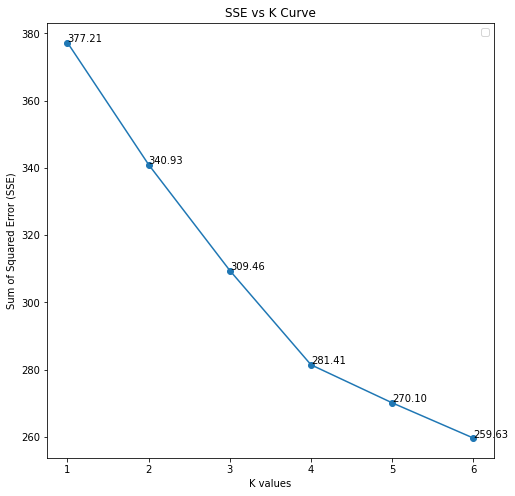

In [28]:
plt.figure(figsize=(8,8))
label = ''
K_values = list(sse_info.keys())
sse_values = list(map(lambda info : info[0], sse_info.values()))
plt.plot(K_values, sse_values, label=label, marker='o')  
plt.xticks(np.arange(min(K_values), max(K_values) + 1, 1))
plt.title("SSE vs K Curve") 
plt.xlabel("K values")
plt.ylabel("Sum of Squared Error (SSE)")
plt.legend()

#Writing values for the curve plot
for k, sse in zip(K_values, sse_values):
    plt.text(k, sse+0.2, str("{:.2f}".format(sse)))


Cluster Size vs Cluster Index curve

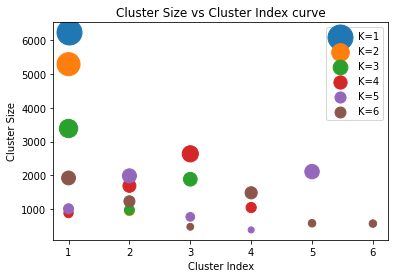

In [33]:
max_iter = 0
outputs = []
for i, k in enumerate(K_values):
  cluster_size = sse_info[k][1]
  size = [c // 10 for c in cluster_size]
  #plt.subplot(plt_rows, plt_cols, i+1)
  label = "K={}".format(k)
  max_iter = max(max_iter, len(cluster_size))
  plt.scatter(range(1, len(cluster_size) +1), cluster_size,s=size, label=label)

  outputs.append({
      "K value": k,
      "Sum of Squared Error": sse_info[k][0],
      "Cluster Sizes": sse_info[k][1]
  })

plt.xticks(range(1, max_iter + 1))
plt.title("Cluster Size vs Cluster Index curve") 
plt.xlabel("Cluster Index")
plt.ylabel("Cluster Size")
plt.legend()
  

In [34]:
pd.options.display.float_format = "{:,.4f}".format
pd.DataFrame(outputs)

,K value,Sum of Squared Error,Cluster Sizes
0,1,377.2097,[6245]
1,2,340.9336,"[5298, 947]"
2,3,309.4571,"[3388, 974, 1883]"
3,4,281.4147,"[879, 1686, 2637, 1043]"
4,5,270.1042,"[1007, 1983, 767, 379, 2109]"
5,6,259.6326,"[1921, 1228, 472, 1480, 577, 567]"
